In [5]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [6]:
# Download do dataset MNIST into data dir
! wget https://pjreddie.com/media/files/mnist_train.csv -P data

--2024-08-29 19:56:27--  https://pjreddie.com/media/files/mnist_train.csv
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [text/csv]
Saving to: ‘data/mnist_train.csv’

mnist_train.csv     100%[===================>] 104.50M  33.7MB/s    in 3.1s    

2024-08-29 19:56:31 (33.7 MB/s) - ‘data/mnist_train.csv’ saved [109575994/109575994]



In [7]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]
        # As demais colunas são os pixels da imagem
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

In [9]:
# Criando índices aleatórios para os subsets de treino e teste
np.random.seed(42)
indices = np.arange(len(mnist_dataset))
np.random.shuffle(indices)

# Dividindo os índices em trainset e testset
num_train = 1000
num_val = 500
num_test = 500
train_indices = indices[:num_train]  # Primeiros 1.000 índices para o trainset
val_indices = indices[num_train:num_train+num_val]  # Próximos 500 índices para o valset
test_indices = indices[num_train+num_val:num_train+num_val+num_test]  # Mais 500 para o testset

trainset = Subset(mnist_dataset, train_indices)
valset = Subset(mnist_dataset, val_indices)
testset = Subset(mnist_dataset, test_indices)

# Criando DataLoaders para os subsets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [10]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [11]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(12 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, 12 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [12]:
model = CNN(
    initialize_weights=True,
    dropout=0.2
)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [14]:
# Treinando a CNN
history = train_model(
    model=model,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
)

100%|██████████| 16/16 [00:01<00:00, 15.71it/s]


Epoch 1, Train Loss: 2.234, Train Accuracy: 18.10%
Epoch 1, Val Loss: 2.028, Val Accuracy: 41.20%


100%|██████████| 16/16 [00:00<00:00, 21.43it/s]


Epoch 2, Train Loss: 1.667, Train Accuracy: 46.60%
Epoch 2, Val Loss: 1.069, Val Accuracy: 67.00%


100%|██████████| 16/16 [00:00<00:00, 21.13it/s]


Epoch 3, Train Loss: 0.861, Train Accuracy: 71.70%
Epoch 3, Val Loss: 0.519, Val Accuracy: 84.80%


100%|██████████| 16/16 [00:00<00:00, 21.14it/s]


Epoch 4, Train Loss: 0.558, Train Accuracy: 81.80%
Epoch 4, Val Loss: 0.458, Val Accuracy: 86.20%


100%|██████████| 16/16 [00:00<00:00, 21.25it/s]


Epoch 5, Train Loss: 0.413, Train Accuracy: 86.50%
Epoch 5, Val Loss: 0.420, Val Accuracy: 87.00%
Treinamento concluído


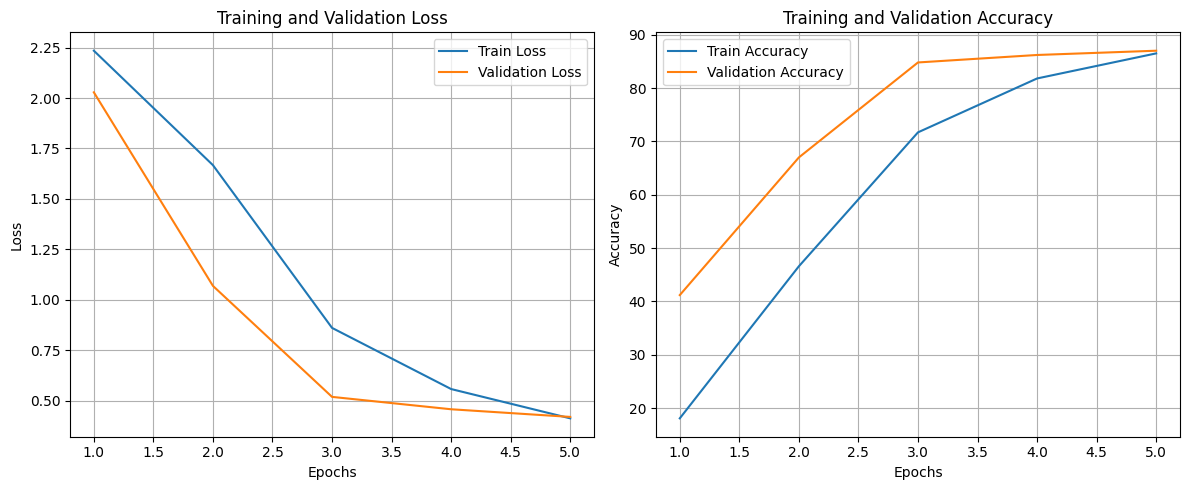

In [15]:
epochs = range(1, len(history['train_losses']) + 1)

# Plot de losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, history['train_losses'], label='Train Loss')
plt.plot(epochs, history['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot de accuracies
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
test_model(model, testloader)

Acurácia da rede na base de teste: 88.60%


## Exercícios

### Exercício 1
Na CNN implementada, execute experimentos variando:
- O número de filtros convolucionais em `self.conv1` (6 e 8)
- O número de filtros convolucionais em `self.conv2` (12 e 16)

Ao final, observe qual combinação desempenha melhor no conjunto de testes.

Dica: Adicionar argumentos no construtor da classe para determinar o número de filtros em cada camada pode ser útil para inicializar diversos modelos.

In [17]:
class CNN(nn.Module):
    def __init__(self, num_filters_conv1=6, num_filters_conv2=12, initialize_weights=True, dropout=0.2):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, num_filters_conv1, 5)
        self.conv2 = nn.Conv2d(num_filters_conv1, num_filters_conv2, 5)
        self.fc1 = nn.Linear(num_filters_conv2 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, self.fc1.in_features)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)


In [18]:
# Função para realizar o treinamento e teste da rede
def run_experiment(conv1_filters, conv2_filters):
    model = CNN(num_filters_conv1=conv1_filters, num_filters_conv2=conv2_filters)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    history = train_model(
        model=model,
        trainloader=trainloader,
        valloader=valloader,
        criterion=criterion,
        optimizer=optimizer
    )

    test_model(model, testloader)
    return history


In [19]:
# Rodando os experimentos
experiment_1 = run_experiment(conv1_filters=6, conv2_filters=12)
experiment_2 = run_experiment(conv1_filters=6, conv2_filters=16)
experiment_3 = run_experiment(conv1_filters=8, conv2_filters=12)
experiment_4 = run_experiment(conv1_filters=8, conv2_filters=16)


100%|██████████| 16/16 [00:00<00:00, 17.33it/s]


Epoch 1, Train Loss: 2.272, Train Accuracy: 15.20%
Epoch 1, Val Loss: 2.136, Val Accuracy: 33.60%


100%|██████████| 16/16 [00:01<00:00, 15.70it/s]


Epoch 2, Train Loss: 1.902, Train Accuracy: 40.00%
Epoch 2, Val Loss: 1.412, Val Accuracy: 65.20%


100%|██████████| 16/16 [00:01<00:00, 14.45it/s]


Epoch 3, Train Loss: 1.147, Train Accuracy: 63.30%
Epoch 3, Val Loss: 0.708, Val Accuracy: 75.80%


100%|██████████| 16/16 [00:00<00:00, 21.67it/s]


Epoch 4, Train Loss: 0.657, Train Accuracy: 78.70%
Epoch 4, Val Loss: 0.462, Val Accuracy: 84.00%


100%|██████████| 16/16 [00:00<00:00, 21.22it/s]


Epoch 5, Train Loss: 0.465, Train Accuracy: 84.40%
Epoch 5, Val Loss: 0.407, Val Accuracy: 87.20%
Treinamento concluído
Acurácia da rede na base de teste: 91.00%


100%|██████████| 16/16 [00:00<00:00, 21.12it/s]


Epoch 1, Train Loss: 2.283, Train Accuracy: 10.90%
Epoch 1, Val Loss: 2.197, Val Accuracy: 27.80%


100%|██████████| 16/16 [00:00<00:00, 21.49it/s]


Epoch 2, Train Loss: 2.042, Train Accuracy: 36.30%
Epoch 2, Val Loss: 1.839, Val Accuracy: 51.20%


100%|██████████| 16/16 [00:00<00:00, 22.08it/s]


Epoch 3, Train Loss: 1.461, Train Accuracy: 53.90%
Epoch 3, Val Loss: 0.908, Val Accuracy: 76.60%


100%|██████████| 16/16 [00:00<00:00, 20.86it/s]


Epoch 4, Train Loss: 0.796, Train Accuracy: 75.60%
Epoch 4, Val Loss: 0.551, Val Accuracy: 84.20%


100%|██████████| 16/16 [00:00<00:00, 21.43it/s]


Epoch 5, Train Loss: 0.514, Train Accuracy: 82.50%
Epoch 5, Val Loss: 0.403, Val Accuracy: 87.60%
Treinamento concluído
Acurácia da rede na base de teste: 87.60%


100%|██████████| 16/16 [00:00<00:00, 20.83it/s]


Epoch 1, Train Loss: 2.225, Train Accuracy: 21.70%
Epoch 1, Val Loss: 2.083, Val Accuracy: 38.60%


100%|██████████| 16/16 [00:00<00:00, 18.19it/s]


Epoch 2, Train Loss: 1.815, Train Accuracy: 39.30%
Epoch 2, Val Loss: 1.272, Val Accuracy: 63.00%


100%|██████████| 16/16 [00:01<00:00, 14.78it/s]


Epoch 3, Train Loss: 1.055, Train Accuracy: 64.70%
Epoch 3, Val Loss: 0.684, Val Accuracy: 77.60%


100%|██████████| 16/16 [00:01<00:00, 14.69it/s]


Epoch 4, Train Loss: 0.669, Train Accuracy: 76.80%
Epoch 4, Val Loss: 0.494, Val Accuracy: 84.40%


100%|██████████| 16/16 [00:00<00:00, 21.15it/s]


Epoch 5, Train Loss: 0.459, Train Accuracy: 85.10%
Epoch 5, Val Loss: 0.360, Val Accuracy: 88.60%
Treinamento concluído
Acurácia da rede na base de teste: 90.60%


100%|██████████| 16/16 [00:00<00:00, 21.16it/s]


Epoch 1, Train Loss: 2.293, Train Accuracy: 12.50%
Epoch 1, Val Loss: 2.166, Val Accuracy: 28.20%


100%|██████████| 16/16 [00:00<00:00, 20.97it/s]


Epoch 2, Train Loss: 1.978, Train Accuracy: 36.80%
Epoch 2, Val Loss: 1.548, Val Accuracy: 59.40%


100%|██████████| 16/16 [00:01<00:00, 12.35it/s]


Epoch 3, Train Loss: 1.199, Train Accuracy: 61.20%
Epoch 3, Val Loss: 0.653, Val Accuracy: 79.20%


100%|██████████| 16/16 [00:01<00:00, 11.87it/s]


Epoch 4, Train Loss: 0.679, Train Accuracy: 77.50%
Epoch 4, Val Loss: 0.474, Val Accuracy: 86.20%


100%|██████████| 16/16 [00:00<00:00, 21.32it/s]


Epoch 5, Train Loss: 0.486, Train Accuracy: 83.30%
Epoch 5, Val Loss: 0.469, Val Accuracy: 85.40%
Treinamento concluído
Acurácia da rede na base de teste: 89.40%


**Observação dos Resultados:** Após realizar os treinamentos com diferentes combinações de filtros, observe qual combinação apresentou a melhor performance (menor perda e maior acurácia no conjunto de teste).

### Exercício 2

Na CNN implementada, execute 5 treinamentos variando aleatoriamente o número de neurônios de saída em `self.fc1` (o valor atual é 64 e também deve ser alterado na entrada da próxima camada).

Como você determinaria qual foi o melhor valor?

In [20]:
import numpy as np

def run_experiment_with_neurons(num_neurons):
    class CNNWithNeurons(nn.Module):
        def __init__(self, num_neurons_fc1, initialize_weights=True, dropout=0.2):
            super(CNNWithNeurons, self).__init__()
            self.conv1 = nn.Conv2d(1, 6, 5)
            self.conv2 = nn.Conv2d(6, 12, 5)
            self.fc1 = nn.Linear(12 * 4 * 4, num_neurons_fc1)
            self.fc2 = nn.Linear(num_neurons_fc1, 10)
            self.dropout = nn.Dropout(dropout)

            if initialize_weights:
                self._initialize_weights()

        def forward(self, x):
            x = F.relu(self.conv1(x))
            x = F.max_pool2d(x, 2, 2)
            x = F.relu(self.conv2(x))
            x = F.max_pool2d(x, 2, 2)
            x = x.view(-1, self.fc1.in_features)
            x = self.dropout(F.relu(self.fc1(x)))
            x = self.fc2(x)
            return x

        def _initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight)
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)

    # Criando e treinando o modelo
    model = CNNWithNeurons(num_neurons_fc1=num_neurons)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    history = train_model(
        model=model,
        trainloader=trainloader,
        valloader=valloader,
        criterion=criterion,
        optimizer=optimizer
    )

    test_model(model, testloader)
    return history



In [21]:
# Testando com 5 números de neurônios diferentes
for i in range(5):
    num_neurons = np.random.randint(10, 100)
    print(f"Teste com {num_neurons} neurônios na camada fully connected")
    run_experiment_with_neurons(num_neurons)
    print()

Teste com 55 neurônios na camada fully connected


100%|██████████| 16/16 [00:00<00:00, 22.32it/s]


Epoch 1, Train Loss: 2.236, Train Accuracy: 17.80%
Epoch 1, Val Loss: 2.085, Val Accuracy: 34.60%


100%|██████████| 16/16 [00:00<00:00, 19.61it/s]


Epoch 2, Train Loss: 1.833, Train Accuracy: 41.60%
Epoch 2, Val Loss: 1.346, Val Accuracy: 58.80%


100%|██████████| 16/16 [00:00<00:00, 16.02it/s]


Epoch 3, Train Loss: 1.202, Train Accuracy: 59.30%
Epoch 3, Val Loss: 0.776, Val Accuracy: 75.00%


100%|██████████| 16/16 [00:01<00:00, 14.42it/s]


Epoch 4, Train Loss: 0.754, Train Accuracy: 74.90%
Epoch 4, Val Loss: 0.549, Val Accuracy: 82.40%


100%|██████████| 16/16 [00:00<00:00, 19.26it/s]


Epoch 5, Train Loss: 0.544, Train Accuracy: 82.20%
Epoch 5, Val Loss: 0.424, Val Accuracy: 87.80%
Treinamento concluído
Acurácia da rede na base de teste: 87.60%

Teste com 78 neurônios na camada fully connected


100%|██████████| 16/16 [00:00<00:00, 21.64it/s]


Epoch 1, Train Loss: 2.243, Train Accuracy: 18.40%
Epoch 1, Val Loss: 2.144, Val Accuracy: 32.80%


100%|██████████| 16/16 [00:00<00:00, 21.91it/s]


Epoch 2, Train Loss: 1.975, Train Accuracy: 37.90%
Epoch 2, Val Loss: 1.618, Val Accuracy: 57.60%


100%|██████████| 16/16 [00:00<00:00, 21.40it/s]


Epoch 3, Train Loss: 1.277, Train Accuracy: 60.50%
Epoch 3, Val Loss: 0.887, Val Accuracy: 70.20%


100%|██████████| 16/16 [00:00<00:00, 21.00it/s]


Epoch 4, Train Loss: 0.738, Train Accuracy: 77.30%
Epoch 4, Val Loss: 0.523, Val Accuracy: 83.40%


100%|██████████| 16/16 [00:02<00:00,  7.66it/s]


Epoch 5, Train Loss: 0.520, Train Accuracy: 82.00%
Epoch 5, Val Loss: 0.433, Val Accuracy: 86.80%
Treinamento concluído
Acurácia da rede na base de teste: 88.40%

Teste com 90 neurônios na camada fully connected


100%|██████████| 16/16 [00:01<00:00,  8.17it/s]


Epoch 1, Train Loss: 2.260, Train Accuracy: 15.90%
Epoch 1, Val Loss: 2.147, Val Accuracy: 25.00%


100%|██████████| 16/16 [00:02<00:00,  5.96it/s]


Epoch 2, Train Loss: 1.878, Train Accuracy: 37.50%
Epoch 2, Val Loss: 1.489, Val Accuracy: 58.20%


100%|██████████| 16/16 [00:00<00:00, 22.19it/s]


Epoch 3, Train Loss: 1.155, Train Accuracy: 62.50%
Epoch 3, Val Loss: 0.725, Val Accuracy: 77.40%


100%|██████████| 16/16 [00:00<00:00, 22.34it/s]


Epoch 4, Train Loss: 0.722, Train Accuracy: 76.00%
Epoch 4, Val Loss: 0.535, Val Accuracy: 85.20%


100%|██████████| 16/16 [00:00<00:00, 22.58it/s]


Epoch 5, Train Loss: 0.483, Train Accuracy: 84.90%
Epoch 5, Val Loss: 0.432, Val Accuracy: 86.40%
Treinamento concluído
Acurácia da rede na base de teste: 87.40%

Teste com 61 neurônios na camada fully connected


100%|██████████| 16/16 [00:00<00:00, 21.32it/s]


Epoch 1, Train Loss: 2.306, Train Accuracy: 12.70%
Epoch 1, Val Loss: 2.245, Val Accuracy: 23.20%


100%|██████████| 16/16 [00:00<00:00, 21.65it/s]


Epoch 2, Train Loss: 2.139, Train Accuracy: 29.30%
Epoch 2, Val Loss: 1.997, Val Accuracy: 37.20%


100%|██████████| 16/16 [00:00<00:00, 21.60it/s]


Epoch 3, Train Loss: 1.676, Train Accuracy: 44.20%
Epoch 3, Val Loss: 1.213, Val Accuracy: 61.00%


100%|██████████| 16/16 [00:00<00:00, 21.37it/s]


Epoch 4, Train Loss: 1.065, Train Accuracy: 63.40%
Epoch 4, Val Loss: 0.707, Val Accuracy: 76.80%


100%|██████████| 16/16 [00:00<00:00, 21.80it/s]


Epoch 5, Train Loss: 0.658, Train Accuracy: 78.50%
Epoch 5, Val Loss: 0.459, Val Accuracy: 85.80%
Treinamento concluído
Acurácia da rede na base de teste: 87.80%

Teste com 20 neurônios na camada fully connected


100%|██████████| 16/16 [00:00<00:00, 18.70it/s]


Epoch 1, Train Loss: 2.282, Train Accuracy: 14.90%
Epoch 1, Val Loss: 2.184, Val Accuracy: 32.20%


100%|██████████| 16/16 [00:01<00:00, 15.86it/s]


Epoch 2, Train Loss: 2.063, Train Accuracy: 31.20%
Epoch 2, Val Loss: 1.773, Val Accuracy: 55.00%


100%|██████████| 16/16 [00:01<00:00, 14.98it/s]


Epoch 3, Train Loss: 1.536, Train Accuracy: 49.80%
Epoch 3, Val Loss: 0.992, Val Accuracy: 75.40%


100%|██████████| 16/16 [00:00<00:00, 20.56it/s]


Epoch 4, Train Loss: 0.978, Train Accuracy: 70.40%
Epoch 4, Val Loss: 0.633, Val Accuracy: 80.20%


100%|██████████| 16/16 [00:00<00:00, 21.17it/s]


Epoch 5, Train Loss: 0.707, Train Accuracy: 76.60%
Epoch 5, Val Loss: 0.428, Val Accuracy: 87.00%
Treinamento concluído
Acurácia da rede na base de teste: 88.80%



**Determinação do Melhor Valor:** Após executar os experimentos, compare os resultados e escolha o número de neurônios que apresentou a melhor performance no conjunto de teste (maior acurácia e menor perda).

**Conclusão:** A abordagem para responder aos exercícios é realizar experimentos com variações de parâmetros na arquitetura da rede e observar os resultados, comparando qual configuração alcança os melhores resultados em termos de acurácia e perda no conjunto de teste.